In [144]:
#%pip install numpy
#%pip install pandas
#%pip install mplfinance
#%pip install matplotlib
#%pip install ta

In [149]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import ta # https://github.com/bukosabino/ta

In [277]:
# в api chatgpt можно передавать картинки размером до 2000 на 768 точек.
# (src: https://platform.openai.com/docs/guides/vision/managing-images : "For high res mode, the short side of the image 
# should be less than 768px and the long side should be less than 2,000px.")
# при этом только картинки 512 на 512 обрабатываются одним блоком. картинки большего размера разбиваются на квадраты
# по 512 на 512 точек.
# в связи с этим я вижу несколько вариантов для размера картинок, которые имеют смысл:
# 1) 512 на 512 - самый дешевый варинт. но сложно вместить всю информацию, которую хочется передать.
# 2) 1024 на 512 - увеличивает стоимость в 2 раза. позволяет большую историю передать.
# 3) 512 на 768 - увеличивает стоимость в 2 раза. позволяет передать больше индикаторов, которые добавляются снизу.
# 4) 1024 на 768 - увеличивает стоимость в 4 раза. среднее количество истории и есть место для индикаторов.
# 5) 1536 на 512 - увеличивает стоимость в 3 раза. достаточно истории, но мало места для индикаторов.
# 6) 1536 на 768 - увеличивает стоимость в 6 раз. достаточно истории и максимум места для индикаторов.
# 7) 2000 на 768 - увеличивает стоимость в 8 раз. максимальный вариант.
# я не уверен, что есть смысл в варианте 7, т.к. на мой вкус такой график выглядит не лучше чем вариант 6. 
# в идеале надо поэкспериментировать.

# DPI в matplotlib = 96 пикселов на дюйм. а размер графика задается в дюймах. поэтому делаю пересчет.
dpi = 96
# 1)
# width_in_inches = 512 / dpi
# height_in_inches = 512 / dpi

# 2)
#width_in_inches = 1024 / dpi
#height_in_inches = 512 / dpi

# 3)
#width_in_inches = 512 / dpi
#height_in_inches = 768 / dpi

# 4)
#width_in_inches = 1024 / dpi
#height_in_inches = 768 / dpi

# 5)
#width_in_inches = 1536 / dpi
#height_in_inches = 512 / dpi

# 6)
width_in_inches = 1536 / dpi
height_in_inches = 768 / dpi

# 7)
#width_in_inches = 2000 / dpi
#height_in_inches = 768 / dpi

# количество свечей на графике
points = 150

### цены за gpt-4o:

- стоимость ввода: $0.005 за 1к

- стоимость вывода: $0.015 за 1к

- стоимость картинки: $0.001275 за 512х512

### оценка стоимости запроса:

ввод: 100 токенов = 0.1 * $0.005 = $0.0005

вывод: 300 токенов = 0.3 * $0.015 = $0.0045

картинка: от $0.001275 до $0.005525


### вывод:

добавление картинки к запросу увеличивает стоимость на от 25% до 110%


note: batch 50% discount: https://platform.openai.com/docs/api-reference/batch

<Axes: >

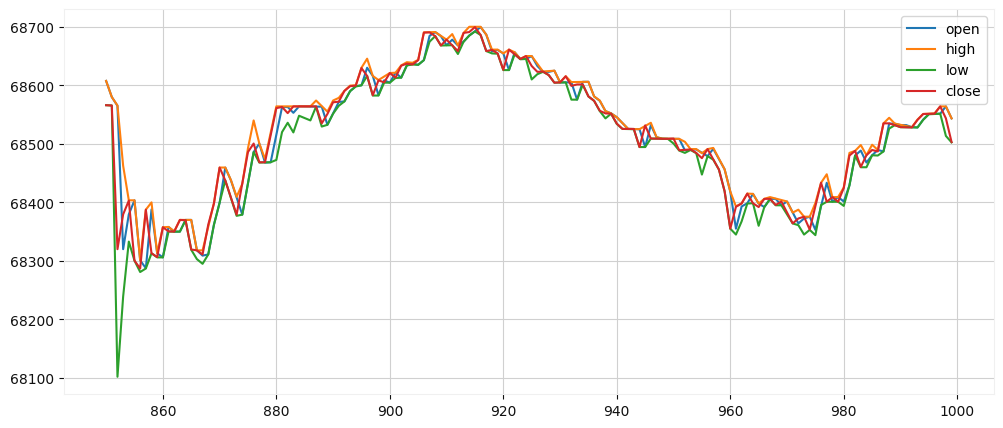

In [301]:
#filename = 'npz/BTCUSD/BTCUSD2023-05-01.npz' # пятисекундные свечи
filename = 'npz/BTCUSD_1T.npz'
#filename = 'npz/BTCUSD_1H.npz'
#filename = 'npz/BTCUSD_D.npz'

# зачитывание в формате numpy
data = np.load(filename, allow_pickle=True)['data']
data = data[-1000:] # беру последние точки, чтобы не напрягать либу технического анализа большим количеством точек.

# преобразование в формат pandas
df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# вывод графика просто, чтобы посмотреть что считалось с диска.
df[['open', 'high', 'low', 'close']][-points:].plot(figsize=(12,5))

In [302]:
# Преобразование 'timestamp' в datetime и установка его как индекс DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Преобразование всех столбцов с ценами и объемом в числовой формат
for column in ['open', 'high', 'low', 'close', 'volume']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [303]:
# добавление функций технического анализа к датафрейму пандас. (дает ворнинг. хз как его убрать.)
df = ta.add_all_ta_features(df, "open", "high", "low", "close", "volume", fillna=True)

/home/stan/src/inv/venv/lib/python3.10/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


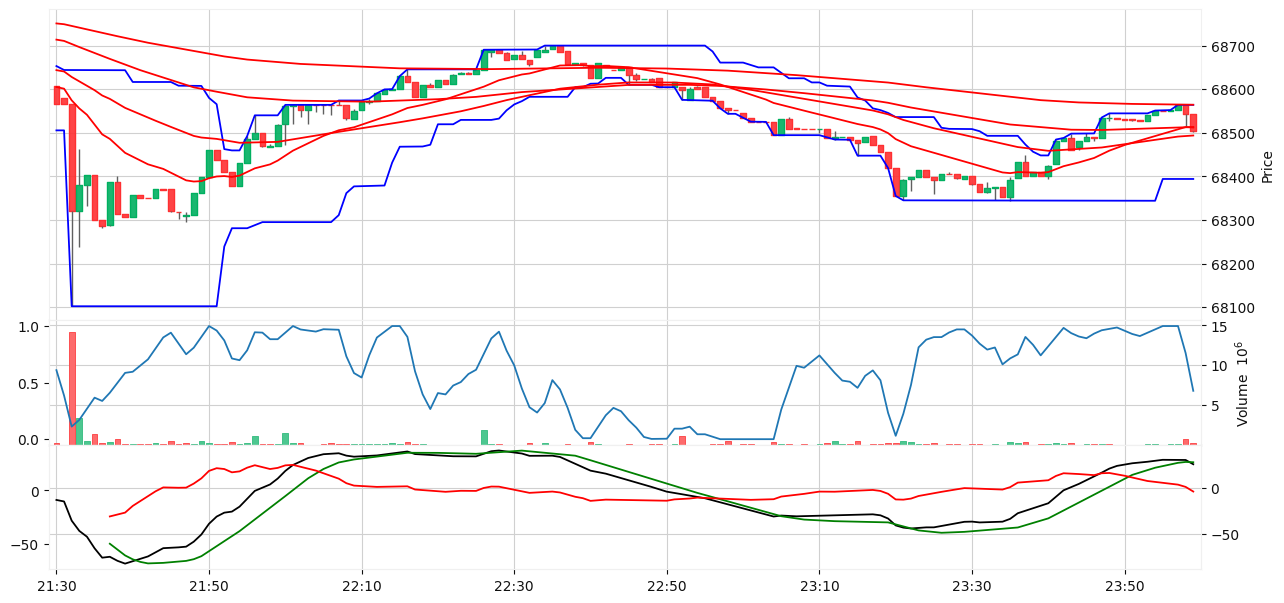

In [325]:
# стиль графика для mpl. пытаюсь сделать что-то похожее на светлую тему tradingview.
customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', facecolor='w')

# wconfig может быть полезн, чтобы считать текущие значения width_config в mpf, чтобы понять что менять.
#wconfig = {}

# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.volatility.DonchianChannel
dc = ta.volatility.DonchianChannel(df[-points-20:]['high'], df[-points-20:]['low'], 20)

# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.momentum.StochRSIIndicator
rsi = ta.momentum.StochRSIIndicator(df[-points-28:]['close'])

# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.ema_indicator
ema20 = ta.trend.ema_indicator(df[-points-20:]['close'], 20)
ema50 = ta.trend.ema_indicator(df[-points-50:]['close'], 50)
ema100 = ta.trend.ema_indicator(df[-points-100:]['close'], 100)
ema200 = ta.trend.ema_indicator(df[-points-200:]['close'], 200)

# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.trend.MACD
macd = ta.trend.MACD(df[-points-26:]['close'], 26)

apdict = [
    mpf.make_addplot(dc.donchian_channel_hband()[-points:], color='blue'),
    mpf.make_addplot(dc.donchian_channel_lband()[-points:], color='blue'),
    mpf.make_addplot(ema20[-points:], color='red'),
    mpf.make_addplot(ema50[-points:], color='red'),
    mpf.make_addplot(ema100[-points:], color='red'),
    mpf.make_addplot(ema200[-points:], color='red'),
    
    mpf.make_addplot(rsi.stochrsi_k()[-points:], panel=1),
    mpf.make_addplot(macd.macd()[-points:], panel=2, color='black'),
    mpf.make_addplot(macd.macd_signal()[-points:], panel=2, color='green'),
    mpf.make_addplot(macd.macd_diff()[-points:], panel=2, color='red'),
    
    #
    #mpf.make_addplot(ta.momentum.ultimate_oscillator(df[-points-26:]['high'],df[-points-26:]['low'],df[-points-26:]['close'])[-points:],panel=3)
    ]
fix, ax = mpf.plot(
    df[-points:],
    type='candle',
    volume=True, 
    style=customstyle,
    figsize=(width_in_inches, height_in_inches),
    returnfig=True, # это надо, чтобы mpf.plot вернул fix, ax.
    # разворот подписей по оси X, т.к. в документации openai написано, что повернутый текст он плохо читает (наверное 
    # умышленно порезана модель, чтобы нельзя было ее использовать для распознавания капчи)
    xrotation=0, 
    #return_width_config=wconfig,
    update_width_config={'volume_width': 0.75, 'candle_width': 0.75, 'candle_linewidth': 1},
    addplot=apdict
    )

ax[0].margins(x=0) # убрать отступы слева и справа на графике.
#wconfig